In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
batch_size = 32
num_workers = 1

# for new_processed
transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder('new_processed/train', transform=transform)
val_data = torchvision.datasets.ImageFolder('new_processed/validation', transform=transform)
test_data = torchvision.datasets.ImageFolder('new_processed/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(len(train_loader), len(val_loader), len(test_loader))

764 164 164


In [3]:
train_dataiter = iter(train_loader)
train_features, train_labels = train_dataiter.next()
print("training:", train_features.shape, train_labels.shape)

training: torch.Size([32, 3, 128, 128]) torch.Size([32])


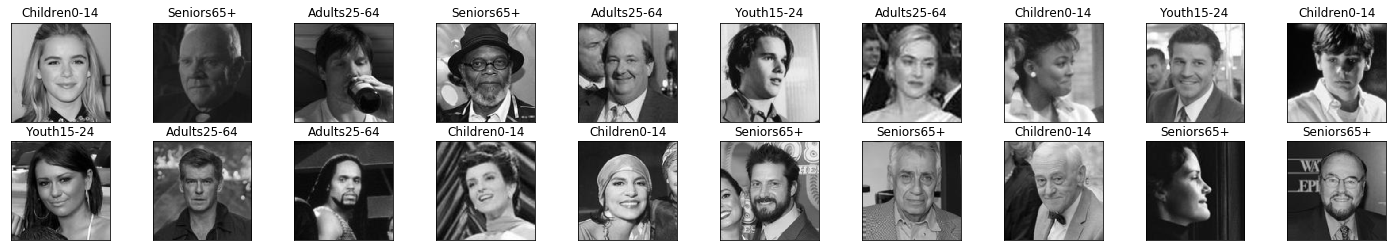

In [4]:
classes = ['Adults25-64', 'Children0-14', 'Seniors65+', 'Youth15-24']
# Verification Step - obtain one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

## Our Model

In [14]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = "AgeNet"
        # input layer is 5*128*128
        self.conv1 = nn.Conv2d(3, 5, 5, stride = 1, padding = 2) # output layer is 5*64*64
        self.pool1 = nn.MaxPool2d(4, 4) # output layer is 5*32*32
        self.conv2 = nn.Conv2d(5, 10, 5, stride = 1, padding = 2) # output layer is 10*32*32
        self.pool2 = nn.MaxPool2d(2, 2)  # output layer is 10*16*16
        self.conv3 = nn.Conv2d(10, 20, 5, stride = 1, padding = 2) # output layer is 15*16*16
        self.fc1 = nn.Linear(20*16*16, 32) # outputing 32
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 20*16*16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

### Training Code

In [10]:
# function that calculates the accuracy
def get_accuracy(model, loader, batch_size):
    correct = 0
    total = 0
    
    for imgs, labels in loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #############################################
        #To Enable GPU Usage
        if use_cuda:
            imgs = imgs.cuda()
            labels = labels.cuda()  
        #############################################
        output = model(imgs)
        prob = F.softmax(output, dim=1)
        #select index with maximum prediction score
        pred = prob.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# function to train the model
def train(model, train_data, batch_size=32, lr=0.01, num_epochs=1, is_overfit=False):
#     torch.manual_seed(2) # set the random seed
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    if is_overfit:
        overfit_loader = torch.utils.data.DataLoader(overfit_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
#     train_iter = iter(train_loader)
    criterion = nn.CrossEntropyLoss() # use cross entropy loss function
    optimizer = optim.Adam(model.parameters(), lr) # use adam optimizer

    iters, train_acc, train_loss, val_acc = [], [], [], []

    # training
    print("training now...")
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            imgs = torch.from_numpy(imgs.detach().numpy())
            #############################################
            #To Enable GPU Usage
            if use_cuda:
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            output = model(imgs)             # forward pass
            prob = F.softmax(output, dim=1)
            loss = criterion(prob, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)    # compute *average* loss
        
        if is_overfit:
            training_accuracy = get_accuracy(model, overfit_loader, batch_size)
            train_acc.append(training_accuracy)
            validation_accuracy = get_accuracy(model, overfit_loader, batch_size)
            val_acc.append(validation_accuracy)
        else:
            training_accuracy = get_accuracy(model, train_loader, batch_size)
            train_acc.append(training_accuracy) # compute training accuracy
            validation_accuracy = get_accuracy(model, val_loader, batch_size)
            val_acc.append(validation_accuracy)

        print("Epoch {} - Training Accuracy: {}, Validation Accuracy: {}".format(
            epoch, training_accuracy, validation_accuracy))
        n += 1

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [5]:
use_cuda = torch.cuda.is_available()

### Overfit to small dataset

training now...
Epoch 0 - Training Accuracy: 0.25, Validation Accuracy: 0.25
Epoch 1 - Training Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch 2 - Training Accuracy: 0.28125, Validation Accuracy: 0.28125
Epoch 3 - Training Accuracy: 0.28125, Validation Accuracy: 0.28125
Epoch 4 - Training Accuracy: 0.28125, Validation Accuracy: 0.28125
Epoch 5 - Training Accuracy: 0.3125, Validation Accuracy: 0.3125
Epoch 6 - Training Accuracy: 0.34375, Validation Accuracy: 0.34375
Epoch 7 - Training Accuracy: 0.40625, Validation Accuracy: 0.40625
Epoch 8 - Training Accuracy: 0.59375, Validation Accuracy: 0.59375
Epoch 9 - Training Accuracy: 0.59375, Validation Accuracy: 0.59375
Epoch 10 - Training Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch 11 - Training Accuracy: 0.59375, Validation Accuracy: 0.59375
Epoch 12 - Training Accuracy: 0.65625, Validation Accuracy: 0.65625
Epoch 13 - Training Accuracy: 0.65625, Validation Accuracy: 0.65625
Epoch 14 - Training Accuracy: 0.65625, Validation Accu

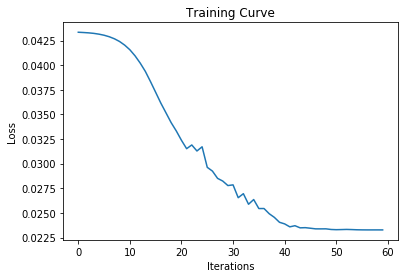

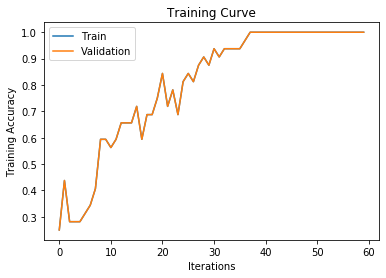

Final Training Accuracy: 1.0
Final Validation Accuracy: 1.0


In [15]:
overfit_data = torchvision.datasets.ImageFolder('new_processed/overfit', transform=transform)
overfit_model = AgeNet()
if use_cuda:
    overfit_model = overfit_model.cuda()
train(overfit_model, overfit_data, batch_size=32, lr=0.001, num_epochs=60, is_overfit=True)

### Train the model

## Use AlexNet

### Cannot make it overfit to small dataset :(

In [ ]:
batch_size = 32
num_workers = 0

# for alex
train_data = torchvision.datasets.DatasetFolder("alex/train", loader=torch.load, extensions=('.tensor'))
val_data = torchvision.datasets.DatasetFolder("alex/validation", loader=torch.load, extensions=('.tensor'))
test_data = torchvision.datasets.DatasetFolder("alex/test", loader=torch.load, extensions=('.tensor'))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# train size
train_dataiter = iter(train_loader)
train_features, train_labels = train_dataiter.next()
print("training:", train_features.shape, train_labels.shape)
# validation size
val_dataiter = iter(val_loader)
val_features, val_labels = val_dataiter.next()
print("validation:", val_features.shape, val_labels.shape)
# test size
test_dataiter = iter(test_loader)
test_features, test_labels = test_dataiter.next()
print("test:", test_features.shape, test_labels.shape)

In [ ]:
# so the input size is now 256*3*3 only LMAO

In [ ]:
class AgeNet(nn.Module):
    def __init__(self):
        super(AgeNet, self).__init__()
        self.name = 'myAlexNet'
        # input layer is 256*3*3
        self.conv1 = nn.Conv2d(256, 256, 2, stride = 1, padding = 1) # output layer is 256*4*4
        self.fc1 = nn.Linear(256*4*4, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 256*4*4) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
overfit_model = AgeNet()
if use_cuda:
    overfit_model = overfit_model.cuda()
train(overfit_model, train_data, batch_size=32, lr=0.001, num_epochs=30, is_overfit=True)

In [ ]:
model = AgeNet()
if use_cuda:
    model = model.cuda()
train(model, train_data, batch_size=32, lr=0.001, num_epochs=30)